# CICDDoS2019

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from py.functions import (
    plot_confusion_matrix, 
    criar_stream, 
    carregar_e_unificar,
    visualizar_radares_separados_referencia,
    visualizar_assinaturas_barras
)

In [47]:
ARQUIVOS_ALVO = [
    'datasets\CICDDoS2019\data\CICDDoS2019_01_12_balanceado.csv',  
    'datasets\CICDDoS2019\data\CICDDoS2019_03_11_balanceado.csv'     
]

CHUNK_SIZE = 100000  

df = carregar_e_unificar(ARQUIVOS_ALVO, CHUNK_SIZE)
df.value_counts("Label")

Iniciando processamento integral de 2 arquivos...
Dataset Unificado Pronto: 2000263 linhas.


Label
Syn              123215
Portmap          121524
MSSQL            121234
TFTP             120511
UDPLag           119680
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
NetBIOS          117459
UDP              117152
DrDoS_DNS        116641
DrDoS_UDP        115985
LDAP             115946
DrDoS_LDAP       115536
DrDoS_NTP        114251
BENIGN           113828
DrDoS_SNMP       113522
Name: count, dtype: int64

In [ ]:
# relatorio_grupos = analisar_grupos_similares(df_analise, top_features, limiar=0.98)
# display(relatorio_grupos)

# identificar_assinaturas_por_ataque(df_analise, 5, 10000, n_iteracoes=10)

## Processamento 

### Downsample 

In [57]:
def processar_e_salvar_dia(
        dia, 
        dataset_path, 
        chunk_size, 
        cols_to_drop, 
        attack_order, 
        output_files, 
        ATTACK_LABEL_COL,
        BENIGN_LABEL,
        DOWNSAMPLE_FACTORS,
        MIN_SAMPLES_PER_CHUNK
    ):
    
    lista_arquivos = attack_order[dia]
    output_filepath = output_files[dia]
    total_amostras_mantidas = 0
    header_escrito = False

    LABEL_COL_LIMPA = ATTACK_LABEL_COL.strip() 
    COLS_DROP_LIMPA = [c.strip() for c in cols_to_drop]

    with open(output_filepath, 'w', newline='', encoding='utf-8') as f:
        
        for filename in lista_arquivos:
            filepath = os.path.join(dataset_path, dia, filename)
            attack_name_from_file = filename.replace('.csv', '')
            
            try:
                csv_reader = pd.read_csv(
                    filepath, 
                    chunksize=chunk_size, 
                    low_memory=False, 
                    on_bad_lines='skip'
                )
            except Exception:
                continue
                
            for df_chunk in csv_reader:
                
                # Remove espaços das colunas do DATAFRAME (O que você já fez)
                df_chunk.columns = df_chunk.columns.str.strip()
                
                # Limpeza de Colunas (Usando a lista limpa)
                cols_existentes_drop = [col for col in COLS_DROP_LIMPA if col in df_chunk.columns]
                df_chunk = df_chunk.drop(columns=cols_existentes_drop, errors='ignore')
                
                # Normalização do Rótulo
                if LABEL_COL_LIMPA in df_chunk.columns:
                    df_chunk[LABEL_COL_LIMPA] = df_chunk[LABEL_COL_LIMPA].apply(
                        lambda x: BENIGN_LABEL if 'BENIGN' in str(x).upper() else attack_name_from_file
                    )
                else:
                    # Se não achar a coluna Label mesmo após limpar, pula
                    continue
                
                # Usa a variável limpa para filtrar
                df_benign = df_chunk[df_chunk[LABEL_COL_LIMPA] == BENIGN_LABEL]
                df_ataque = df_chunk[df_chunk[LABEL_COL_LIMPA] != BENIGN_LABEL]

                if not df_ataque.empty:
                    factor = DOWNSAMPLE_FACTORS.get(attack_name_from_file, DOWNSAMPLE_FACTORS['Default'])
                    
                    if len(df_ataque) < MIN_SAMPLES_PER_CHUNK:
                        factor = 1.0
                    
                    if factor < 1.0:
                        df_ataque = df_ataque.sample(frac=factor, random_state=42)

                # Combina e Restaura a Ordem pelo Índice
                df_chunk_reduzido = pd.concat([df_benign, df_ataque])
                df_chunk_reduzido = df_chunk_reduzido.sort_index()
                
                if df_chunk_reduzido.empty:
                    continue

                # Salvamento
                df_chunk_reduzido.to_csv(
                    f, 
                    index=False, 
                    header=not header_escrito, 
                    mode='a' 
                )
                header_escrito = True
                total_amostras_mantidas += len(df_chunk_reduzido)

    return total_amostras_mantidas

In [ ]:
DATASET_PATH = 'datasets/CICDDoS2019/'
PANDAS_CHUNK_SIZE = 100000 
ATTACK_LABEL_COL = ' Label' 
COLUMNS_TO_DROP = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP']
MIN_SAMPLES_PER_CHUNK = 1000
BENIGN_LABEL = 'BENIGN'

# Simula o REAL
# DOWNSAMPLE_FACTORS = {
#     'BENIGN': 1.0,           
#     'WebDDoS': 1.0,          
#     'TFTP': 0.0002,          
#     'DrDoS_DNS': 0.001,      
#     'DrDoS_LDAP': 0.001,
#     'DrDoS_MSSQL': 0.001,
#     'DrDoS_NTP': 0.001,
#     'DrDoS_NetBIOS': 0.001,
#     'DrDoS_SNMP': 0.001,
#     'DrDoS_SSDP': 0.001,
#     'DrDoS_UDP': 0.001,
#     'LDAP': 0.001,            
#     'MSSQL': 0.001,
#     'NetBIOS': 0.001,
#     'UDP': 0.001,
#     'Syn': 0.0015,            
#     'UDPLag': 0.005,           
#     'Portmap': 0.01,          
#     'Default': 0.001          
# }

# A Classe Ataques Majoritária
# DOWNSAMPLE_FACTORS = {
#     'WebDDoS': 1.0,          
#     'TFTP': 0.001,           
#     # Reflexão Massiva
#     'DrDoS_DNS': 0.01,       
#     'DrDoS_LDAP': 0.01,
#     'DrDoS_MSSQL': 0.01,
#     'DrDoS_NTP': 0.01,
#     'DrDoS_NetBIOS': 0.01,
#     'DrDoS_SNMP': 0.01,
#     'DrDoS_SSDP': 0.01,
#     'DrDoS_UDP': 0.01,
#     # FAMÍLIA EXPLORAÇÃO/REFLEXÃO 
#     'LDAP': 0.01,            
#     'MSSQL': 0.01,
#     'NetBIOS': 0.01,
#     'UDP': 0.01,
#     # FAMÍLIA TÁTICA 
#     'Syn': 0.05,             
#     'Portmap': 0.1,          
#     'UDPLag': 0.2,           
#     'Default': 0.01          
# }


# A concatenação dos 2 dias fica balanceado (Grande)
DOWNSAMPLE_FACTORS = {
    'WebDDoS': 1.0,          
    'Syn': 0.021,             
    'UDPLag': 0.11,           
    'TFTP': 0.006,           
    'DrDoS_SNMP': 0.022,      
    'DrDoS_DNS': 0.023,       
    'DrDoS_MSSQL': 0.026,     
    'DrDoS_NetBIOS': 0.029,   
    'DrDoS_UDP': 0.037,       
    'DrDoS_SSDP': 0.045,      
    'DrDoS_LDAP': 0.053,      
    'DrDoS_NTP': 0.095,       
    'MSSQL': 0.021,           
    'NetBIOS': 0.034,         
    'UDP': 0.031,             
    'LDAP': 0.055,            
    'Portmap': 0.65,          
    'Default': 0.02           
}

ATTACK_ORDER = {
    '03-11': [
        'Portmap.csv', 'NetBIOS.csv', 'LDAP.csv', 'MSSQL.csv', 'UDP.csv', 'UDPLag.csv', 'Syn.csv'
    ],
    '01-12': [
        'DrDoS_NTP.csv', 'DrDoS_DNS.csv', 'DrDoS_LDAP.csv', 'DrDoS_MSSQL.csv', 'DrDoS_NetBIOS.csv', 'DrDoS_SNMP.csv', 'DrDoS_SSDP.csv', 'DrDoS_UDP.csv', 
        'UDPLag.csv', 'Syn.csv', 'TFTP.csv' 
    ]
}

OUTPUT_FILES = {
    '03-11': 'CICDDoS2019_03_11.csv',
    '01-12': 'CICDDoS2019_01_12.csv'
}

dia_0311 = processar_e_salvar_dia(
    dia='03-11', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['03-11']} (Total: {dia_0311:,} amostras)")

dia_0112 = processar_e_salvar_dia(
    dia='01-12', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['01-12']} (Total: {dia_0112:,} amostras)")

Dataset salvo: CICDDoS2019_03_11.csv (Total: 819,585 amostras)
Dataset salvo: CICDDoS2019_01_12.csv (Total: 1,180,678 amostras)


### Verificação da Base de dados gerada

Label
TFTP             120511
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
DrDoS_DNS        116641
DrDoS_UDP        115985
DrDoS_LDAP       115536
DrDoS_NTP        114251
DrDoS_SNMP       113522
BENIGN            56863
UDPLag            40359
Syn               33231
Name: count, dtype: int64


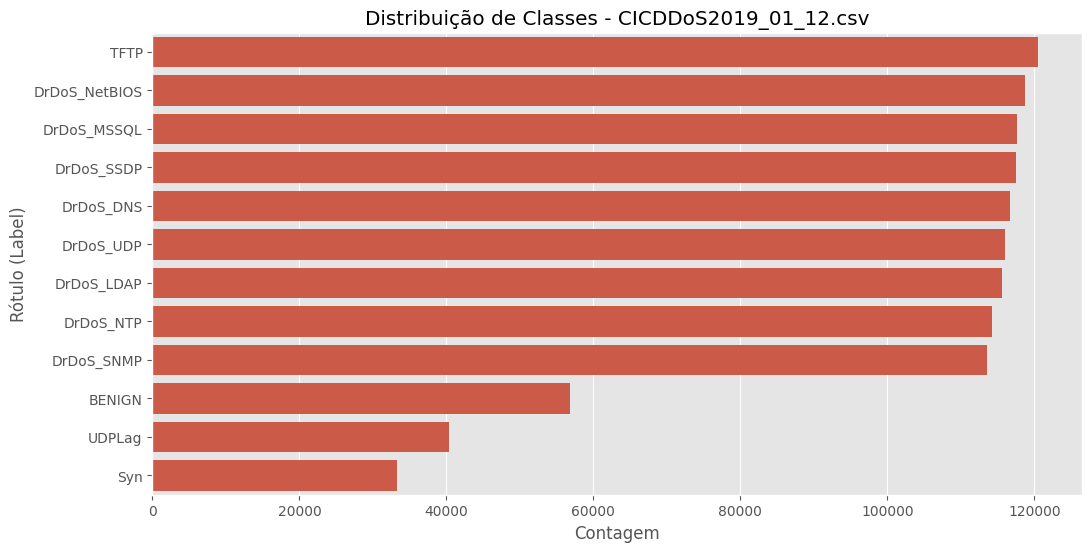

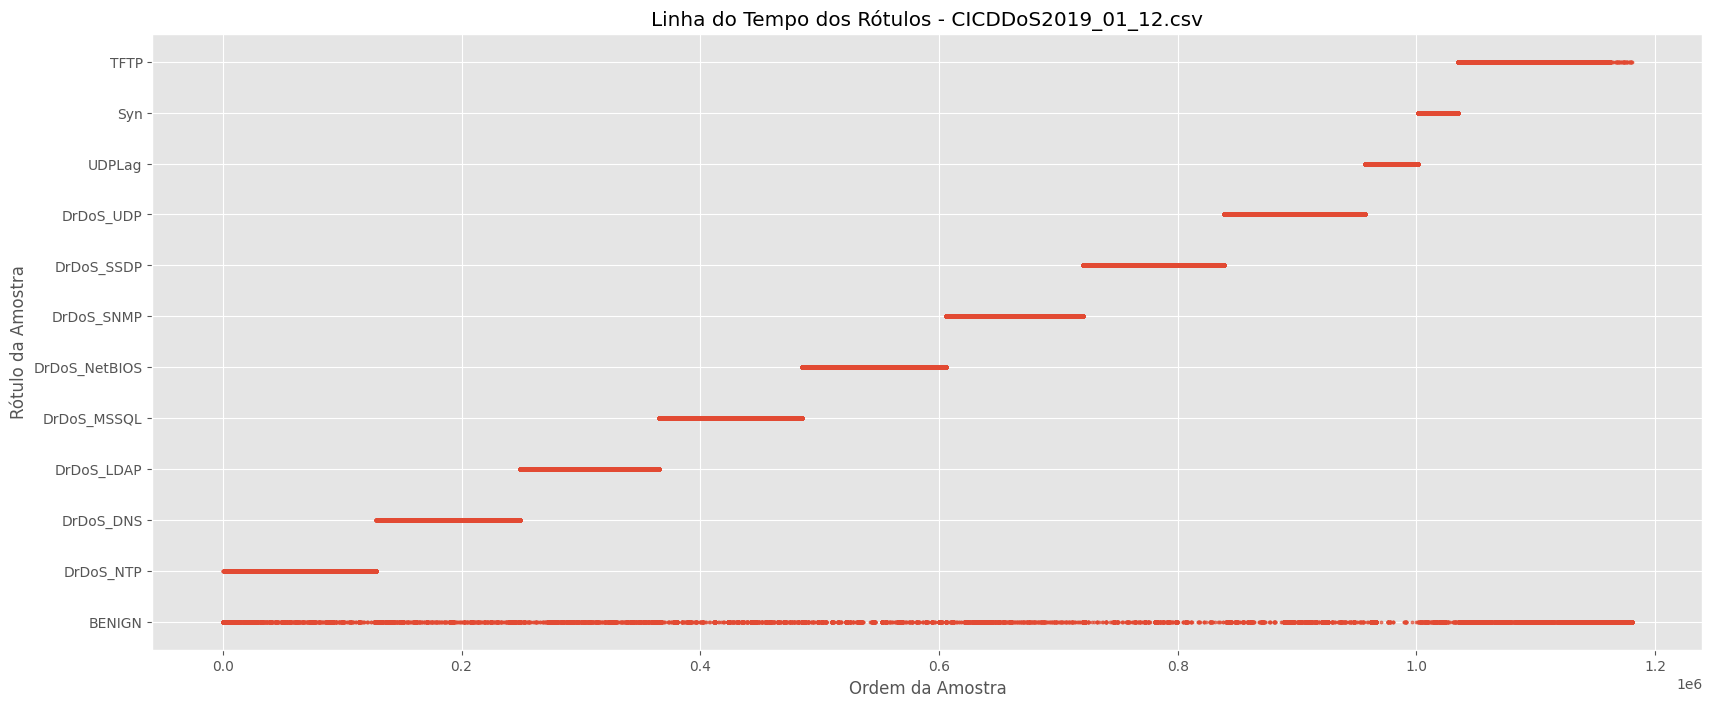

In [71]:
# --- Análise Exploratória do Dataset  ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) 
plt.style.use('ggplot') 

# --- Carregar o Dataset de Teste ---
# file = 'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'
# file = 'datasets\CICDDoS2019\CICDDoS2019_01_12.csv'
file = 'CICDDoS2019_01_12.csv'

df = pd.read_csv(file)

# --- Contagem de Rótulos ---
print(df['Label'].value_counts())

# --- Gráfico de Contagem de Rótulos ---
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Label'], order=df['Label'].value_counts().index)
plt.title(f'Distribuição de Classes - {file}')
plt.xlabel('Contagem')
plt.ylabel('Rótulo (Label)')
plt.show()

# Ordenar o DataFrame pelo Timestamp e plotar o gráfico da linha do tempo
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_sorted = df.sort_values(by='Timestamp')

# Resetar o index para que o eixo X do gráfico seja a ordem da amostra
df_sorted = df_sorted.reset_index(drop=True)

# --- Gráfico da Ordem dos Rótulos ---
plt.figure(figsize=(20, 8))
plt.scatter(df_sorted.index, df_sorted['Label'], s=5, alpha=0.7)
plt.title(f'Linha do Tempo dos Rótulos - {file}')
plt.xlabel('Ordem da Amostra')
plt.ylabel('Rótulo da Amostra')
plt.show()

## Análise dos Ataques

![Ataques](datasets/CICDDoS2019/img/ataques.png)

### DEVELOP

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from scipy.spatial.distance import squareform

TAMANHO_AMOSTRA = 500000
MEU_THRESHOLD = 0.10
COLUNA_LABEL = 'Label' 

print("1. Preparação dos Dados")

# Amostragem Estratificada Segura
n_por_grupo = TAMANHO_AMOSTRA // len(df[COLUNA_LABEL].unique())

df_amostra = df.groupby(COLUNA_LABEL).apply(
    lambda x: x.sample(n=min(len(x), n_por_grupo), random_state=42),
    include_groups=False 
).reset_index(level=0)

X_raw = df_amostra.drop(columns=[COLUNA_LABEL])
y = df_amostra[COLUNA_LABEL]

# Limpeza e Normalização
X_numeric = X_raw.select_dtypes(include=[np.number]).copy()
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
X_numeric.fillna(X_numeric.median(), inplace=True)

scaler = QuantileTransformer(output_distribution='normal', random_state=42)
X_trans = scaler.fit_transform(X_numeric)
labels_unique = y.unique()

df_amostra.value_counts("Label")

1. Preparação dos Dados


Label
BENIGN           29411
DrDoS_DNS        29411
DrDoS_LDAP       29411
DrDoS_MSSQL      29411
DrDoS_NTP        29411
DrDoS_NetBIOS    29411
DrDoS_SNMP       29411
DrDoS_SSDP       29411
DrDoS_UDP        29411
LDAP             29411
MSSQL            29411
NetBIOS          29411
Portmap          29411
Syn              29411
TFTP             29411
UDP              29411
UDPLag           29411
Name: count, dtype: int64

In [62]:
print("2. Seleção de Features e Extração de Assinaturas ")

#  Selecionar as Top 20 Features 
rf_sel = RandomForestClassifier(n_estimators=150, max_depth=20, n_jobs=-1, random_state=42)
le = LabelEncoder()
y_num = le.fit_transform(y)
rf_sel.fit(X_trans, y_num)

importancias = rf_sel.feature_importances_
indices_top = np.argsort(importancias)[-20:] # Pega índices das top 20
X_final = X_trans[:, indices_top]            # Filtra dataset
feature_names_final = X_numeric.columns[indices_top]

# Extrair Assinatura de Cada Ataque 
print("   > Extraindo DNA de cada tipo de ataque...")
final_signatures = []

for label in labels_unique:
    y_binary = (y == label).astype(int)
    rf = RandomForestClassifier(n_estimators=150, max_depth=20, max_features='sqrt', n_jobs=-1, random_state=42)
    rf.fit(X_final, y_binary)
    final_signatures.append(rf.feature_importances_)

df_final_sig = pd.DataFrame(final_signatures, index=labels_unique, columns=feature_names_final)

print("   > Matriz de Assinaturas Extraídas...")
display(df_final_sig)

2. Seleção de Features e Extração de Assinaturas 
   > Extraindo DNA de cada tipo de ataque...
   > Matriz de Assinaturas Extraídas...


,Inbound,Subflow Fwd Packets,Flow Packets/s,Fwd IAT Total,Init_Win_bytes_forward,ACK Flag Count,Flow Bytes/s,Fwd Header Length.1,Fwd Header Length,min_seg_size_forward,Total Length of Fwd Packets,Subflow Fwd Bytes,Packet Length Mean,Fwd Packet Length Min,Avg Fwd Segment Size,Min Packet Length,Fwd Packet Length Mean,Average Packet Size,Fwd Packet Length Max,Max Packet Length
BENIGN,0.285434,0.019503,0.010050,0.003922,0.116776,1.341474e-01,0.005322,0.018544,0.009554,0.012161,0.014521,0.011699,0.023897,0.058534,0.040242,0.061977,0.040575,0.041051,0.037581,0.054509
DrDoS_DNS,0.003294,0.001062,0.059237,0.050057,0.001003,4.042448e-06,0.062468,0.078062,0.085346,0.074978,0.029925,0.024266,0.062502,0.080271,0.055891,0.086596,0.054977,0.095136,0.051969,0.042954
DrDoS_LDAP,0.000162,0.000616,0.033552,0.034290,0.000580,1.488510e-05,0.046965,0.050804,0.050468,0.050680,0.020664,0.015081,0.094515,0.118175,0.075498,0.151269,0.075458,0.080009,0.060799,0.040400
DrDoS_MSSQL,0.001000,0.022361,0.016568,0.031253,0.000195,6.611746e-08,0.035334,0.046921,0.048647,0.052686,0.135297,0.125180,0.040923,0.070672,0.064157,0.055248,0.055949,0.076335,0.054015,0.067261
DrDoS_NTP,0.004671,0.112762,0.057169,0.044439,0.005924,7.438002e-04,0.040087,0.013440,0.010461,0.003629,0.196365,0.186683,0.047492,0.021193,0.054812,0.012440,0.044508,0.027076,0.064109,0.051996
DrDoS_NetBIOS,0.000286,0.000637,0.007887,0.009956,0.011158,3.480640e-05,0.013170,0.109767,0.098687,0.119670,0.046810,0.056097,0.068988,0.070805,0.057156,0.077771,0.075355,0.045014,0.073035,0.057714
DrDoS_SNMP,0.000112,0.000978,0.114707,0.128297,0.000104,5.574792e-05,0.157924,0.022460,0.022612,0.022896,0.023413,0.026717,0.039786,0.073126,0.065356,0.088833,0.063862,0.053789,0.055891,0.039080
DrDoS_SSDP,0.000723,0.004742,0.083584,0.087716,0.002125,4.766242e-05,0.069441,0.046956,0.045010,0.054107,0.024982,0.026778,0.068162,0.091363,0.059476,0.064093,0.087570,0.035266,0.081321,0.066538
DrDoS_UDP,0.000985,0.002773,0.084741,0.089921,0.001924,2.206276e-04,0.065894,0.031500,0.033421,0.034136,0.030193,0.025749,0.058551,0.097864,0.065410,0.076530,0.108155,0.050331,0.087788,0.053914
LDAP,0.000088,0.000692,0.054376,0.060921,0.000189,1.788836e-05,0.163462,0.082283,0.085289,0.090528,0.017116,0.013238,0.064287,0.072179,0.046608,0.097366,0.041414,0.052925,0.031686,0.025338


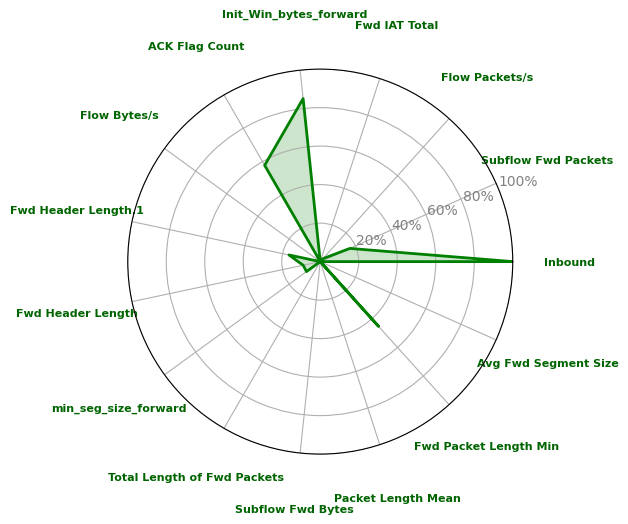

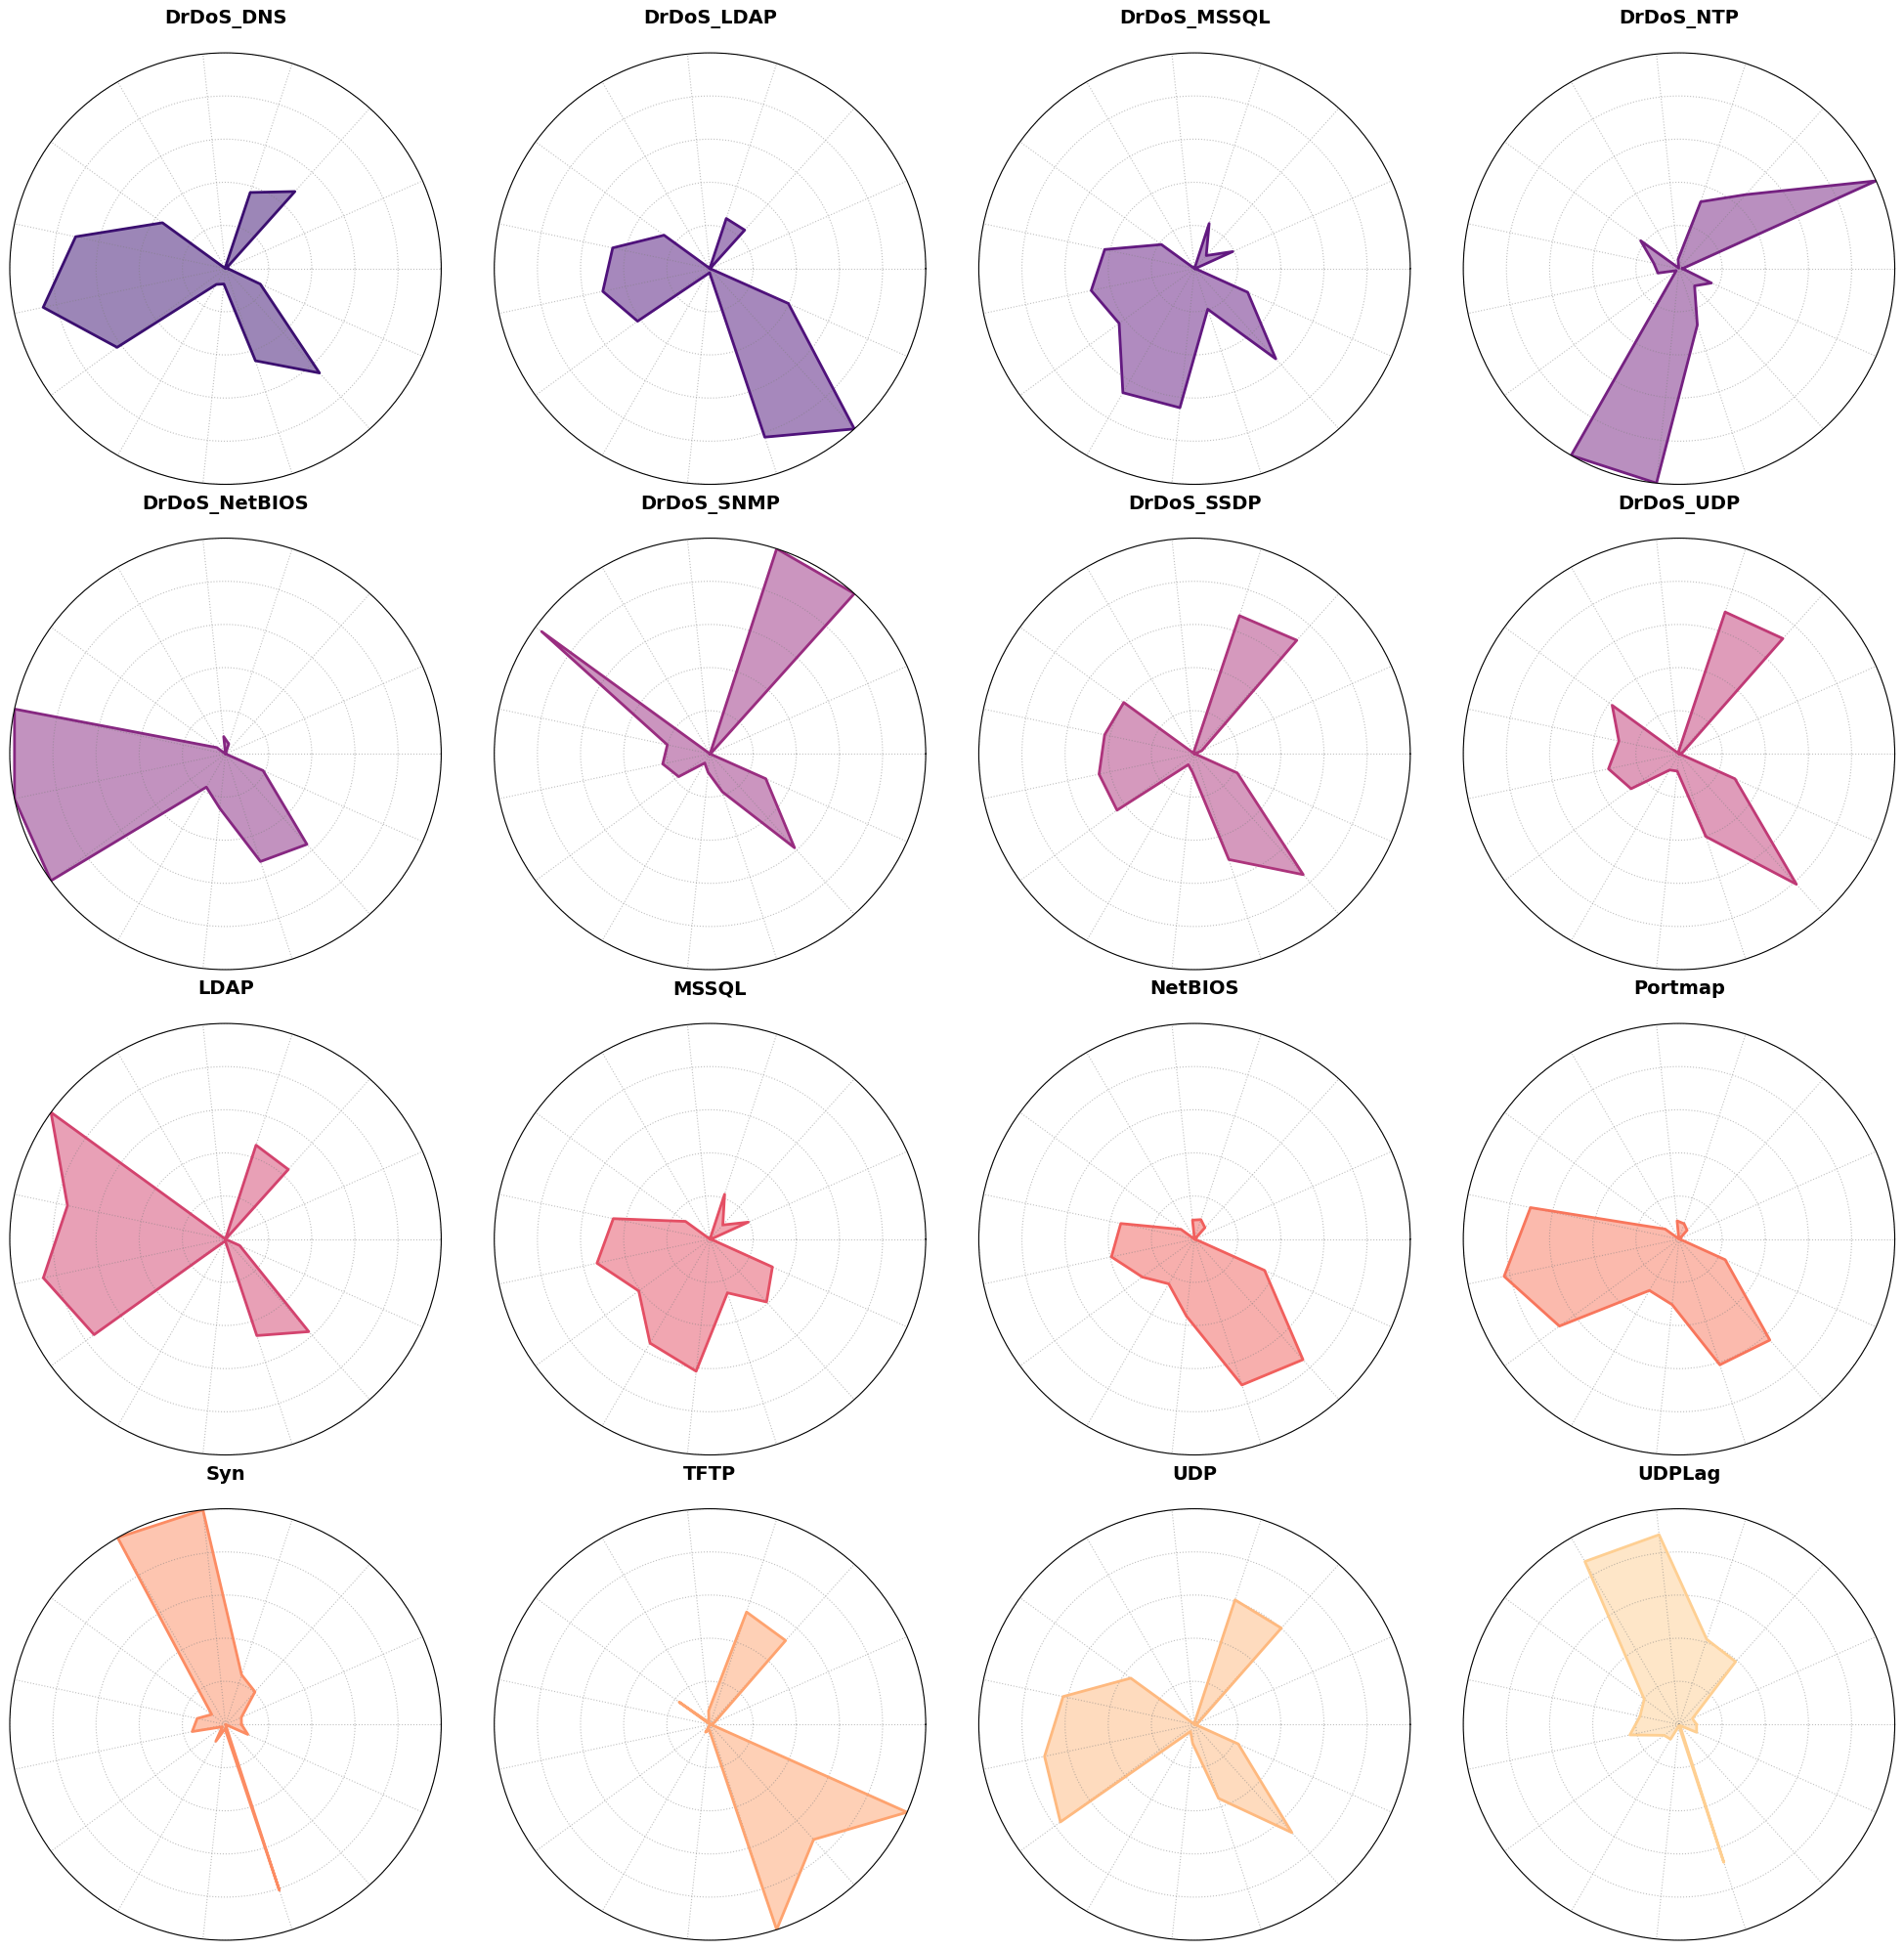

In [63]:
features_para_plotar = df_final_sig.columns[:15].tolist() 

df_radar_ready = df_final_sig.copy()
df_radar_ready = df_radar_ready.reset_index() 
df_radar_ready = df_radar_ready.rename(columns={'index': 'Label'})

visualizar_radares_separados_referencia(df_radar_ready, features_para_plotar)

In [64]:
print("3. Cálculo de Distância e Definição de Grupos")

# Matriz de Distância
final_sim = cosine_similarity(df_final_sig)
final_dist = 1 - final_sim
np.fill_diagonal(final_dist, 0)
final_dist = np.clip(final_dist, 0, 1)
dist_condensada = squareform(final_dist)

print(f"   > Aplicando corte com Threshold={MEU_THRESHOLD}...")
final_clustering = AgglomerativeClustering(
    n_clusters=None,              
    distance_threshold=MEU_THRESHOLD, 
    metric='precomputed', 
    linkage='complete'
)
final_labels = final_clustering.fit_predict(final_dist)

3. Cálculo de Distância e Definição de Grupos
   > Aplicando corte com Threshold=0.1...


,Grupo ID,Ataques,Similaridade Interna,Assinatura
0,0,"DrDoS_DNS, DrDoS_LDAP",0.9262,"Min Packet Length, Fwd Packet Length Min, Average Packet Size"
1,1,"DrDoS_SSDP, DrDoS_UDP, UDP",0.9682,"Fwd Packet Length Mean, Fwd Packet Length Min, Fwd IAT Total"
2,2,"DrDoS_MSSQL, MSSQL",0.9913,"Total Length of Fwd Packets, Subflow Fwd Bytes, Average Packet Size"
3,3,"DrDoS_NetBIOS, Portmap",0.9714,"min_seg_size_forward, Fwd Header Length.1, Fwd Header Length"
4,4,NetBIOS,1.0000,"Min Packet Length, Fwd Packet Length Mean, Fwd Packet Length Min"
5,5,DrDoS_NTP,1.0000,"Total Length of Fwd Packets, Subflow Fwd Bytes, Subflow Fwd Packets"
6,6,TFTP,1.0000,"Max Packet Length, Avg Fwd Segment Size, Packet Length Mean"
7,7,"Syn, UDPLag",0.9899,"ACK Flag Count, Init_Win_bytes_forward, Max Packet Length"
8,8,LDAP,1.0000,"Flow Bytes/s, Min Packet Length, min_seg_size_forward"
9,9,BENIGN,1.0000,"Inbound, ACK Flag Count, Init_Win_bytes_forward"


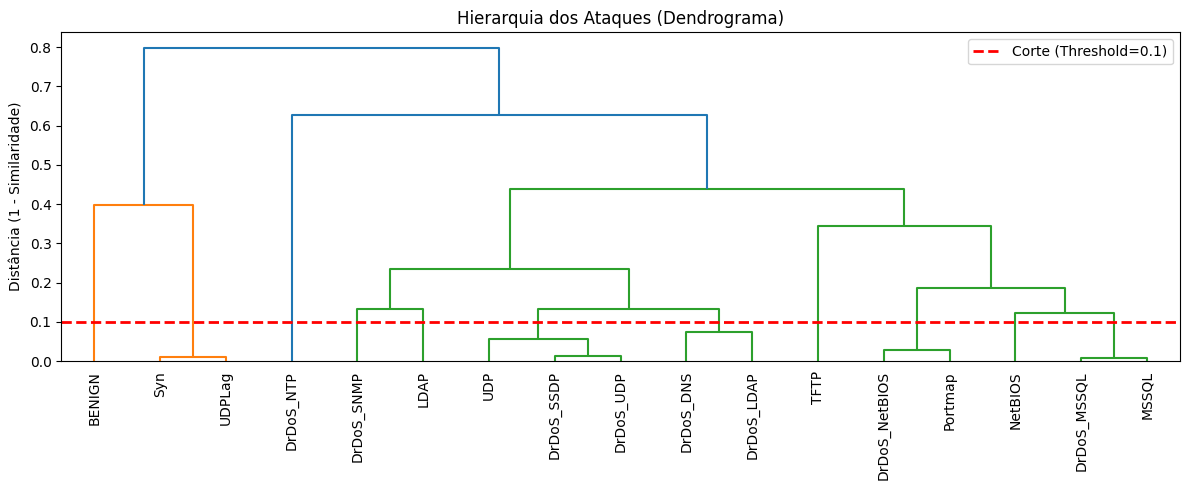

In [65]:
report = []

for cid in sorted(set(final_labels)):
    membros = df_final_sig.index[final_labels == cid].tolist()
    
    # Média de similaridade interna
    if len(membros) > 1:
        sub_sim = pd.DataFrame(final_sim, index=labels_unique, columns=labels_unique).loc[membros, membros]
        mask = np.ones(sub_sim.shape, dtype=bool)
        np.fill_diagonal(mask, 0)
        avg_sim = sub_sim.values[mask].mean()
    else:
        avg_sim = 1.000
        
    # Principais características do grupo
    avg_imp = df_final_sig.loc[membros].mean()
    top_feats = avg_imp.nlargest(3).index.tolist()
    
    report.append({
        'Grupo ID': cid,
        'Ataques': ", ".join(membros),
        'Similaridade Interna': f"{avg_sim:.4f}",
        'Assinatura': ", ".join(top_feats)
    })

display(pd.DataFrame(report))

#  VISUALIZAÇÃO DENDROGRAMA
plt.figure(figsize=(12, 5))
Z = linkage(dist_condensada, method='complete')
dendrogram(Z, labels=labels_unique, leaf_rotation=90., leaf_font_size=10.)
plt.axhline(y=MEU_THRESHOLD, c='r', ls='--', lw=2, label=f'Corte (Threshold={MEU_THRESHOLD})')
plt.title("Hierarquia dos Ataques (Dendrograma)")
plt.ylabel("Distância (1 - Similaridade)")
plt.legend()
plt.tight_layout()
plt.show()


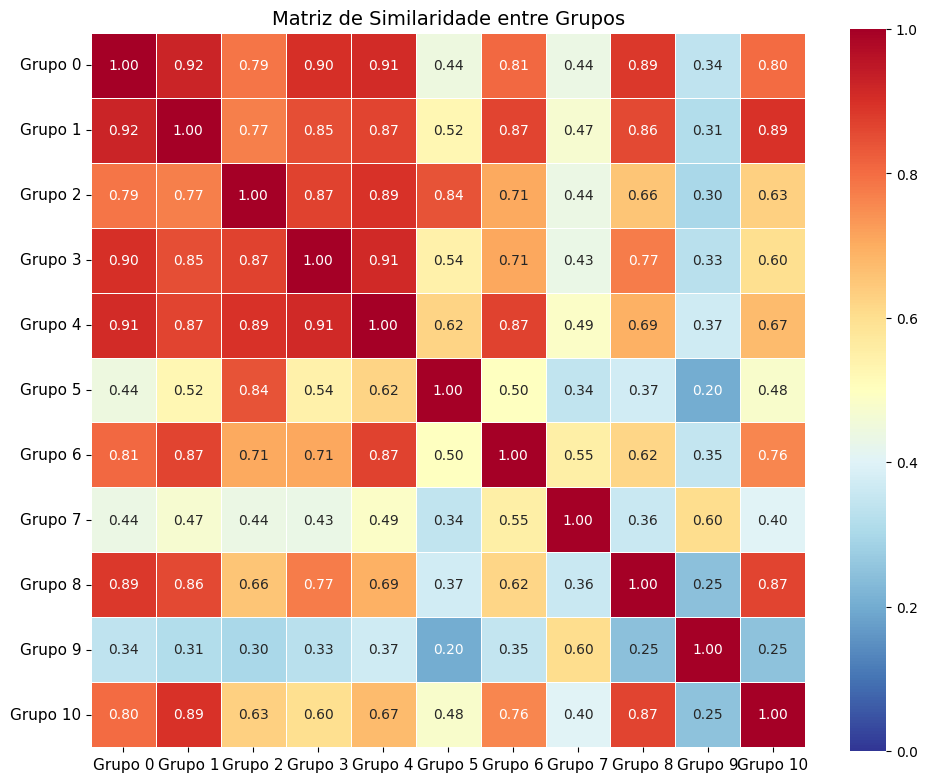

In [66]:
# Recuperando dados brutos da memória
unique_clusters = sorted(list(set(final_labels)))
cluster_vectors = []
cluster_names = []

for cid in unique_clusters:
    # Encontra índices dos ataques neste cluster
    indices = [i for i, label in enumerate(final_labels) if label == cid]
    
    # Calcula o vetor médio (Centróide)
    mean_vector = df_final_sig.iloc[indices].mean().values
    cluster_vectors.append(mean_vector)
    cluster_names.append(f"Grupo {cid}")

# Calcula similaridade
cluster_sim_matrix = cosine_similarity(cluster_vectors)
df_cluster_sim = pd.DataFrame(cluster_sim_matrix, index=cluster_names, columns=cluster_names)

# 1. Plotar Heatmap (Matriz Limpa)
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_cluster_sim, 
    annot=True, 
    fmt=".2f", 
    cmap='RdYlBu_r', 
    vmin=0, 
    vmax=1,
    square=True,
    linewidths=.5
)
plt.title("Matriz de Similaridade entre Grupos", fontsize=14)
plt.xticks(rotation=0, fontsize=11) 
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

## Base de dados para verificar se os modelos identificam a semelhança entre os ataques durante o treinamento

In [17]:
import pandas as pd
import numpy as np
import os

def gerar_cenario_dinamico(df, sequencia_labels, pct_sujeira, tamanho_bloco_ataque, nome_cenario, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    df = df.drop(columns=['Origem_Arquivo', 'Unnamed: 0'], errors='ignore')
    
    df_benign_pool = df[df['Label'] == 'BENIGN'].sample(frac=1, random_state=42)
    total_benign_disponivel = len(df_benign_pool)
    
    qtd_ataques = len([x for x in sequencia_labels if x != 'BENIGN'])
    qtd_intervalos_benign = len([x for x in sequencia_labels if x == 'BENIGN'])
    
    qtd_ruido_por_ataque = int(tamanho_bloco_ataque * pct_sujeira)
    qtd_ataque_puro = int(tamanho_bloco_ataque * (1 - pct_sujeira))
    
    total_ruido_necessario = qtd_ruido_por_ataque * qtd_ataques
    
    if total_ruido_necessario > total_benign_disponivel:
        raise ValueError(f"Erro: Não há dados benignos suficientes para o ruído solicitado. Necessário: {total_ruido_necessario}, Disponível: {total_benign_disponivel}")
    
    df_noise_pool = df_benign_pool.iloc[:total_ruido_necessario]
    df_benign_intervals_pool = df_benign_pool.iloc[total_ruido_necessario:]
    
    tamanho_intervalo_benign = 0
    if qtd_intervalos_benign > 0:
        tamanho_intervalo_benign = int(len(df_benign_intervals_pool) / qtd_intervalos_benign)
    
    df_list = []
    metadata = []
    indice_global = 0
    
    idx_noise = 0
    idx_interval = 0
    
    for label in sequencia_labels:
        if label == 'BENIGN':
            start = idx_interval * tamanho_intervalo_benign
            end = start + tamanho_intervalo_benign
            
            chunk = df_benign_intervals_pool.iloc[start:end]
            df_list.append(chunk)
            
            metadata.append({
                'Evento': f"BENIGN_Intervalo_{idx_interval+1}",
                'Inicio': indice_global,
                'Fim': indice_global + len(chunk),
                'Tipo': 'Normal'
            })
            
            indice_global += len(chunk)
            idx_interval += 1
            
        else:
            start_noise = idx_noise * qtd_ruido_por_ataque
            end_noise = start_noise + qtd_ruido_por_ataque
            noise_chunk = df_noise_pool.iloc[start_noise:end_noise]
            
            try:
                attack_raw = df[df['Label'] == label].sample(n=qtd_ataque_puro, random_state=42 + idx_noise)
            except ValueError:
                print(f"Aviso: Dados insuficientes para o ataque {label}. Usando o que tem disponível.")
                attack_raw = df[df['Label'] == label]
            
            attack_block = pd.concat([attack_raw, noise_chunk]).sample(frac=1, random_state=42)
            df_list.append(attack_block)
            
            metadata.append({
                'Evento': f"ATAQUE_{label}",
                'Inicio': indice_global,
                'Fim': indice_global + len(attack_block),
                'Tipo': 'Ataque'
            })
            
            indice_global += len(attack_block)
            idx_noise += 1
            
    df_final = pd.concat(df_list, ignore_index=True)
    
    csv_name = f"stream_{nome_cenario}.csv"
    meta_name = f"metadata_{nome_cenario}.csv"
    
    df_final.to_csv(os.path.join(output_dir, csv_name), index=False)
    pd.DataFrame(metadata).to_csv(os.path.join(output_dir, meta_name), index=False)
    
    print(f"Cenário '{nome_cenario}' gerado com sucesso em: {output_dir}")
    print(f"Estrutura: {len(df_final)} linhas | {pct_sujeira*100}% de sujeira nos ataques.")
    
    return df_final, metadata

In [20]:
DIRETORIO_BASE = r"datasets\CICDDoS2019\Experimentos"
TAMANHO_BLOCO = 30000  
SUJEIRA = 0.40         

sequencia_c1 = [
    'BENIGN', 
    'DrDoS_LDAP', 
    'BENIGN', 
    'DrDoS_NetBIOS', 
    'BENIGN', 
    'Syn', 
    'BENIGN'
]

df_c1, meta_c1 = gerar_cenario_dinamico(
    df=df_analise,
    sequencia_labels=sequencia_c1,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Imunidade",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_1")
)

sequencia_c2 = [
    'BENIGN', 
    'DrDoS_UDP', 
    'BENIGN', 
    'DrDoS_MSSQL', 
    'BENIGN', 
    'DrDoS_UDP', 
    'BENIGN'
]

df_c2, meta_c2 = gerar_cenario_dinamico(
    df=df_analise,
    sequencia_labels=sequencia_c2,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Memoria",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_2")
)

sequencia_c3 = [
    'BENIGN', 
    'UDP', 
    'BENIGN', 
    'DrDoS_NTP', 
    'BENIGN', 
    'DrDoS_DNS', 
    'BENIGN'
]

df_c3, meta_c3 = gerar_cenario_dinamico(
    df=df_analise,
    sequencia_labels=sequencia_c3,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Complexidade",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_3")
)

Cenário 'Imunidade' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_1
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.
Cenário 'Memoria' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_2
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.
Cenário 'Complexidade' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_3
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.
